In [2]:
from raytracing import *
import matplotlib.pyplot as plt
import numpy as np 
from raytracing import Material
import ezdxf

%matplotlib widget

DeprecationWarning [in config.py]: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.


257.11


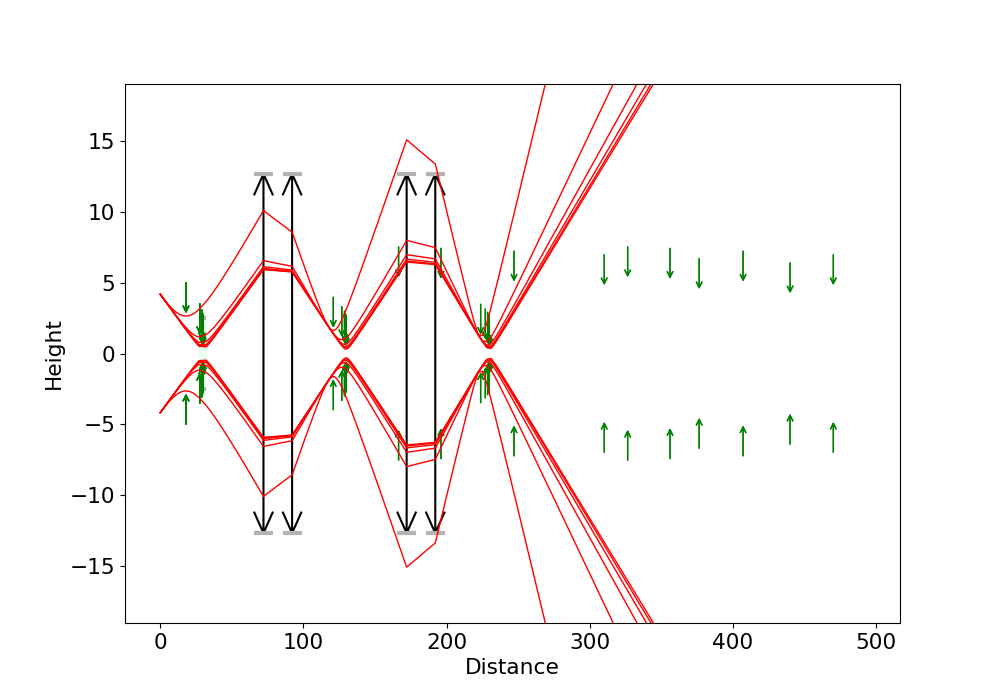

In [26]:
path = LaserPath()

w0 = 1.2  # [mm]
z0 = 27.11
f, D = 40, 25.4
x = 20
path.append(Space(d=z0))
path.append(DielectricSlab(n=1, thickness=5, diameter=5))
path.append(Space(d=f))
path.append(Lens(f=f, diameter=D))
path.append(Space(d=x))
path.append(Lens(f=f, diameter=D))
path.append(Space(d=2*f))
path.append(Lens(f=f, diameter=D))
path.append(Space(d=x))
path.append(Lens(f=f, diameter=D))
path.append(Space(d=300))

print(z0 + 4*f + 2*x + 30)

d = 2 * 30 * np.sin(np.deg2rad(4))
f = np.linspace(0.2, 2, 6)
lda = 0.3 / f # mm
orays = [GaussianBeam(w=d, wavelength=lda[i], R=-30) for i in range(len(lda))]

path.display(beams=orays)

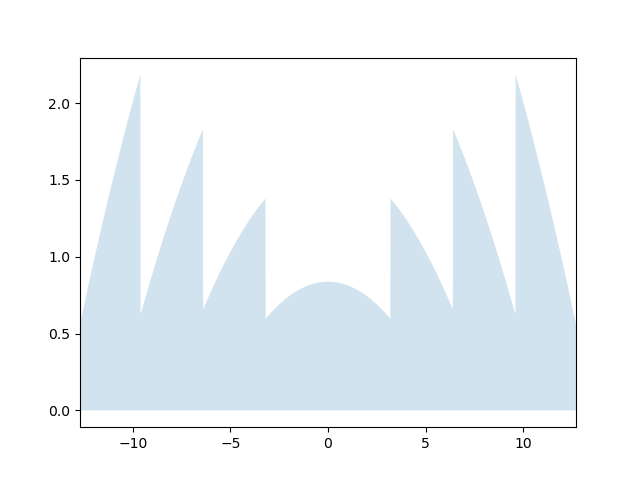

In [81]:
focal_length = 40
diameter = 25.4
index = 1.53
num_segments = 4
radius_of_curvature = focal_length * (index - 1)
thickness = 0.5

radius = np.linspace(0, diameter / 2 + 0.1, 1000)
y = radius**2 / (2 * radius_of_curvature)
y = y[-1] - y

from math import ceil

lda = 0.299792  # [mm], (1 THz)
d = lda / index

y = y[::-1]
indices = np.arange(0, len(y), ceil(len(y) / num_segments))
for i in indices:
    y[i:] -= d * (y[i] // d)
y = y[::-1]
y += thickness

# Store x, y values in a CSV file
np.savetxt("lens_profile.csv", np.array([radius, y]).T, delimiter=",")

fig, ax = plt.subplots()
ax.set(xlim=(-diameter / 2, diameter / 2))
ax.fill_between(
    np.concatenate([-radius[::-1], radius]), np.concatenate([y[::-1], y]), alpha=0.2
)

indices = np.concatenate((indices, [len(y) - 1]))
slices = [slice(indices[i], indices[i + 1] - 2) for i in range(len(indices) - 1)]
# for s in slices:
#     ax.plot(radius[s], y[s])

# Create a new DXF document
doc = ezdxf.new(dxfversion="R2010")

# Add the lens profile as a polyline to the modelspace
msp = doc.modelspace()

connecting_points = [
    (radius[indices[i + 1]], y[indices[i + 1]]) for i in range(len(indices) - 1)
]
spline_coords = [[(x, y) for x, y in zip(radius[s], y[s])] for s in slices]

for i in range(len(spline_coords)):
    msp.add_spline(spline_coords[i])
    msp.add_line(spline_coords[i][-1], connecting_points[i])

msp.add_line(connecting_points[-1], (radius[-1], 0))
msp.add_line((radius[-1], 0), (0, 0))
msp.add_line((0, 0), (0, y[0]))

# Set document units to mm
doc.header["$INSUNITS"] = 4

# Save the DXF document to a file
doc.saveas("lens_profile.dxf")

plt.show()